# Data Preprocessing

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import RobustScaler
from scipy import stats


In [64]:
# Function to load specific datasets
def load_dataset():
    # Determine the current working directory
    current_dir = os.getcwd()
    
    # Create the path to the raw_data directory relative to the current directory
    base_dir = os.path.abspath(os.path.join(current_dir, "..", "raw_data"))
    
# Define the path to the All_Airports.csv file
    all_airports_file_path = os.path.join(base_dir, "All_Airports.csv")
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(all_airports_file_path, compression='zip')
    
    return df

df = load_dataset()


# df = pd.read_csv('/Users/conorjohnston/code/diego-mogollon/lateguru/lateguru/raw_data/Dataset_B_FORWW_Kaggle/All_Airports.csv', compression='zip')

In [65]:
#Inspect DF 

df.head()

,Time,Origin,Dest,Carrier,Cancelled,CancellationReason,Delayed,DepDelayMinutes,CarrierDelay,WeatherDelay,...,LateAircraftDelay,Temperature,Feels_Like_Temperature,Altimeter_Pressure,Sea_Level_Pressure,Visibility,Wind_Speed,Wind_Gust,Precipitation,Ice_Accretion_3hr
0,2021-01-01 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,False,0.0,NaN,NaN,...,NaN,56.0,55.9,1020.32,1020.1,16093.40,0.0,24.97,0.0,0.0
1,2021-01-02 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,True,2.0,NaN,NaN,...,NaN,54.0,54.0,1025.74,1025.5,16093.40,0.0,24.97,0.0,0.0
2,2021-01-03 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,True,28.0,28.0,0.0,...,0.0,52.0,52.0,1024.38,1015.2,4828.02,4.6,24.97,0.0,0.0
3,2021-01-03 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,True,28.0,28.0,0.0,...,0.0,53.0,53.1,1024.38,1024.1,6437.36,4.6,24.97,0.0,0.0
4,2021-01-04 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,False,0.0,NaN,NaN,...,NaN,51.0,51.1,1023.03,1015.2,6437.36,4.6,24.97,0.0,0.0


### Missing Values

In [66]:
#Select Numbers only
df_num = df.select_dtypes(include='number')
print(df_num.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15144514 entries, 0 to 15144513
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   DepDelayMinutes         float64
 1   CarrierDelay            float64
 2   WeatherDelay            float64
 3   NASDelay                float64
 4   SecurityDelay           float64
 5   LateAircraftDelay       float64
 6   Temperature             float64
 7   Feels_Like_Temperature  float64
 8   Altimeter_Pressure      float64
 9   Sea_Level_Pressure      float64
 10  Visibility              float64
 11  Wind_Speed              float64
 12  Wind_Gust               float64
 13  Precipitation           float64
 14  Ice_Accretion_3hr       float64
dtypes: float64(15)
memory usage: 1.7 GB
None


In [67]:
# Check Missing Values
missing_values = df.isnull().sum()

print(missing_values)

Time                             0
Origin                           0
Dest                             0
Carrier                          0
Cancelled                        0
CancellationReason        14804803
Delayed                          0
DepDelayMinutes             328891
CarrierDelay              11870186
WeatherDelay              11870186
NASDelay                  11870186
SecurityDelay             11870186
LateAircraftDelay         11870186
Temperature                      0
Feels_Like_Temperature           0
Altimeter_Pressure               0
Sea_Level_Pressure               0
Visibility                       0
Wind_Speed                       0
Wind_Gust                        0
Precipitation                    0
Ice_Accretion_3hr                0
dtype: int64


In [68]:
len(df)

15144514

In [69]:
# Display rows with missing values in 'DepDelayMinutes'
missing_dep_delay = df_num[df_num['DepDelayMinutes'].isnull()]
print(missing_dep_delay.head())

     DepDelayMinutes  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
82               NaN           NaN           NaN       NaN            NaN   
171              NaN           NaN           NaN       NaN            NaN   
172              NaN           NaN           NaN       NaN            NaN   
173              NaN           NaN           NaN       NaN            NaN   
174              NaN           NaN           NaN       NaN            NaN   

     LateAircraftDelay  Temperature  Feels_Like_Temperature  \
82                 NaN         58.0                    57.9   
171                NaN         47.0                    46.9   
172                NaN         47.0                    46.9   
173                NaN         46.0                    46.0   
174                NaN         47.0                    46.9   

     Altimeter_Pressure  Sea_Level_Pressure  Visibility  Wind_Speed  \
82              1019.30              1019.2    16093.40         0.0   
171             

#### Inspect Missing Values in all relevant columns

In [70]:
# Inspect specific columns with missing values
print(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].head(20))
print(df[['CancellationReason']].head(20))

    DepDelayMinutes  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
0               0.0           NaN           NaN       NaN            NaN   
1               2.0           NaN           NaN       NaN            NaN   
2              28.0          28.0           0.0       2.0            0.0   
3              28.0          28.0           0.0       2.0            0.0   
4               0.0           NaN           NaN       NaN            NaN   
5               0.0           NaN           NaN       NaN            NaN   
6               0.0           NaN           NaN       NaN            NaN   
7               0.0           NaN           NaN       NaN            NaN   
8               0.0           NaN           NaN       NaN            NaN   
9               0.0           NaN           NaN       NaN            NaN   
10              0.0           NaN           NaN       NaN            NaN   
11              0.0           NaN           NaN       NaN            NaN   
12          

In [71]:
# Filter and inspect rows where DepDelayMinutes is NaN
print(df[df['DepDelayMinutes'].isnull()][['DepDelayMinutes', 'Delayed', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].head(20))

# Filter and inspect rows where WeatherDelay is NaN
print(df[df['WeatherDelay'].isnull()][['DepDelayMinutes', 'Delayed', 'WeatherDelay', 'CarrierDelay', 'NASDelay']].head(20))

# Filter and inspect rows where CancellationReason is NaN
print(df[df['CancellationReason'].isnull()][['CancellationReason', 'Cancelled']].head(20))

      DepDelayMinutes  Delayed  CarrierDelay  WeatherDelay  NASDelay  \
82                NaN    False           NaN           NaN       NaN   
171               NaN    False           NaN           NaN       NaN   
172               NaN    False           NaN           NaN       NaN   
173               NaN    False           NaN           NaN       NaN   
174               NaN    False           NaN           NaN       NaN   
175               NaN    False           NaN           NaN       NaN   
487               NaN    False           NaN           NaN       NaN   
1318              NaN    False           NaN           NaN       NaN   
1418              NaN    False           NaN           NaN       NaN   
1485              NaN    False           NaN           NaN       NaN   
1778              NaN    False           NaN           NaN       NaN   
1883              NaN    False           NaN           NaN       NaN   
2100              NaN    False           NaN           NaN      

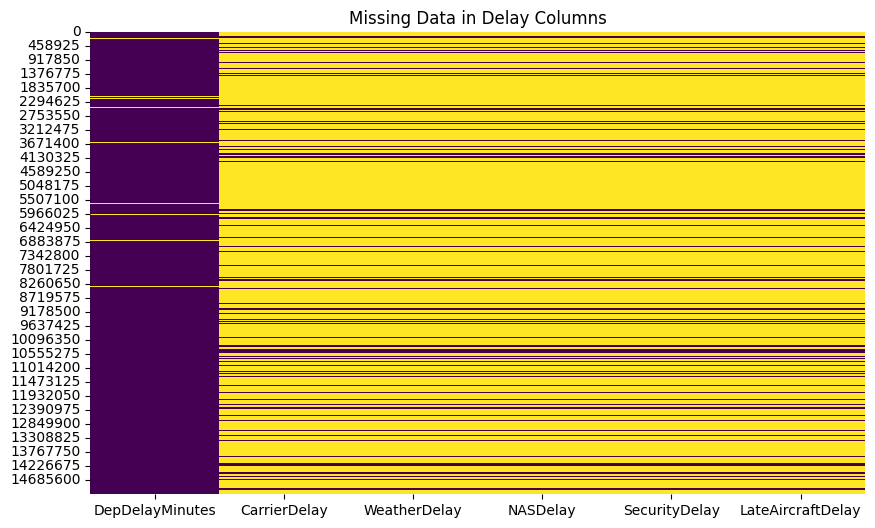

In [72]:
# Visualize missing data in the delay columns
plt.figure(figsize=(10, 6))
sns.heatmap(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data in Delay Columns')
plt.show()

### Data Imputation for NaN

In [73]:
# Impute NaN in delay columns with 0.0
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df[delay_columns] = df[delay_columns].fillna(0.0)

In [74]:
# Impute NaN in DepDelayMinutes with 0.0
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0.0)

In [75]:
# Impute NaN in CancellationReason with 'Not Cancelled'
df['CancellationReason'] = df['CancellationReason'].fillna('Not Cancelled')

In [76]:
# Display the first few rows after imputation to confirm changes
print(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationReason']].head(20))

    DepDelayMinutes  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
0               0.0           0.0           0.0       0.0            0.0   
1               2.0           0.0           0.0       0.0            0.0   
2              28.0          28.0           0.0       2.0            0.0   
3              28.0          28.0           0.0       2.0            0.0   
4               0.0           0.0           0.0       0.0            0.0   
5               0.0           0.0           0.0       0.0            0.0   
6               0.0           0.0           0.0       0.0            0.0   
7               0.0           0.0           0.0       0.0            0.0   
8               0.0           0.0           0.0       0.0            0.0   
9               0.0           0.0           0.0       0.0            0.0   
10              0.0           0.0           0.0       0.0            0.0   
11              0.0           0.0           0.0       0.0            0.0   
12          

### Handling Outliers

In [77]:
# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print(f"Outliers found: {len(outliers[0])}")

Outliers found: 1881233


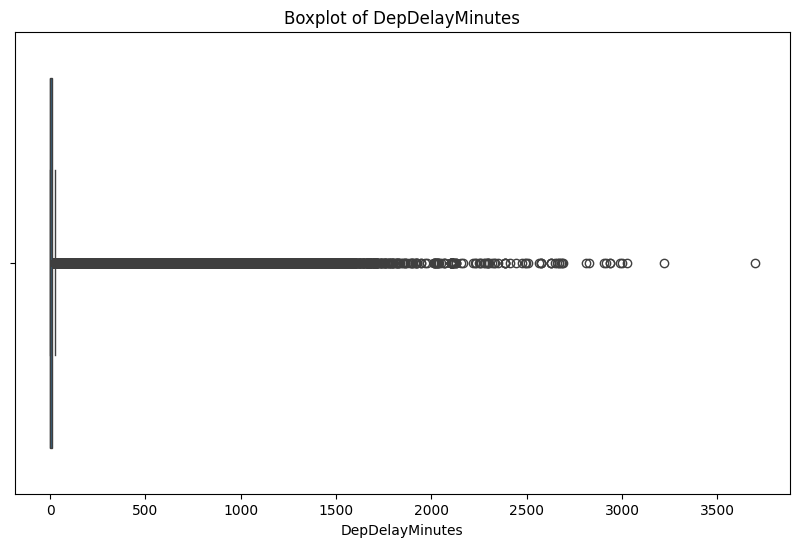

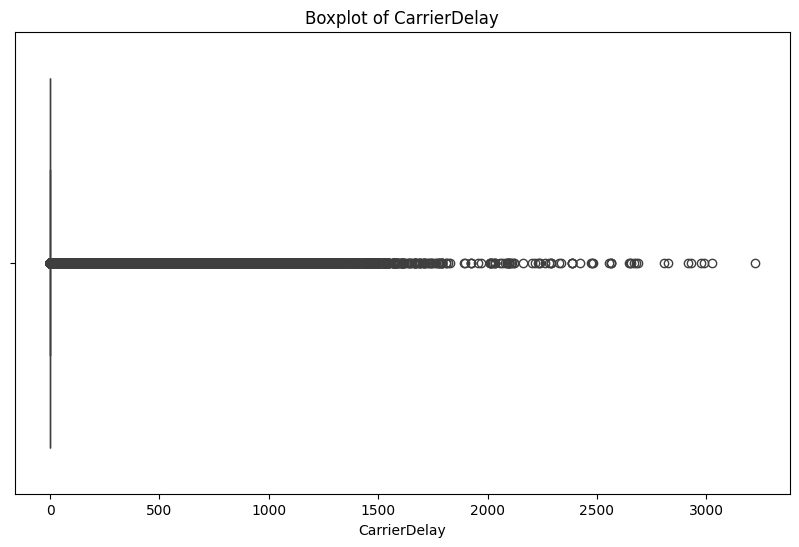

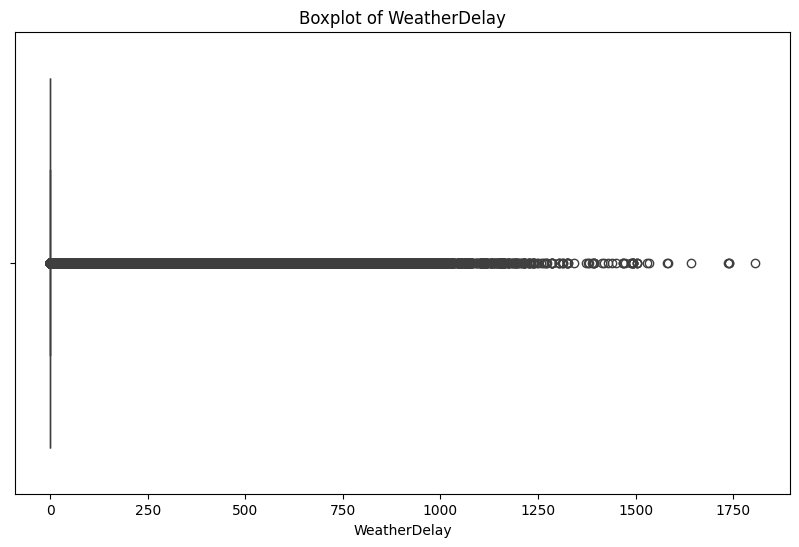

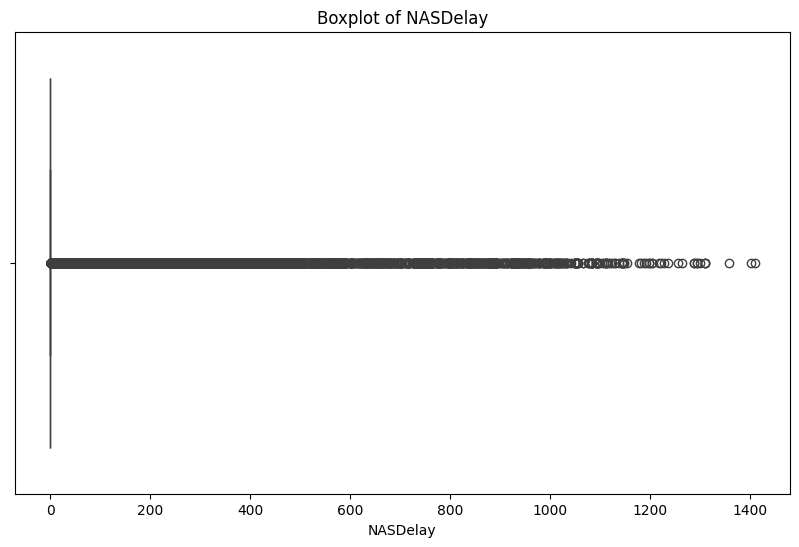

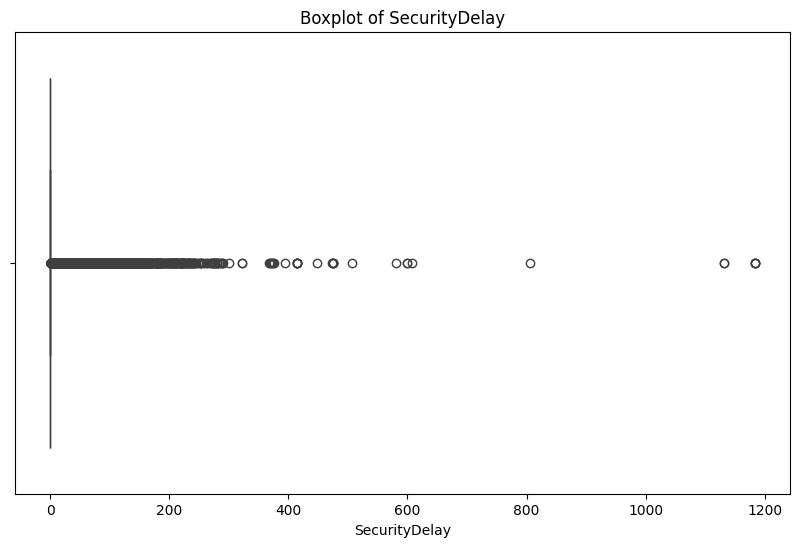

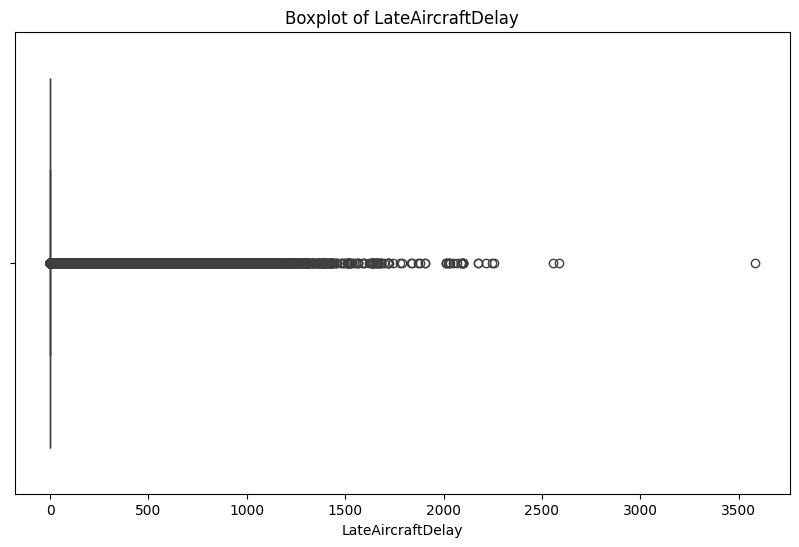

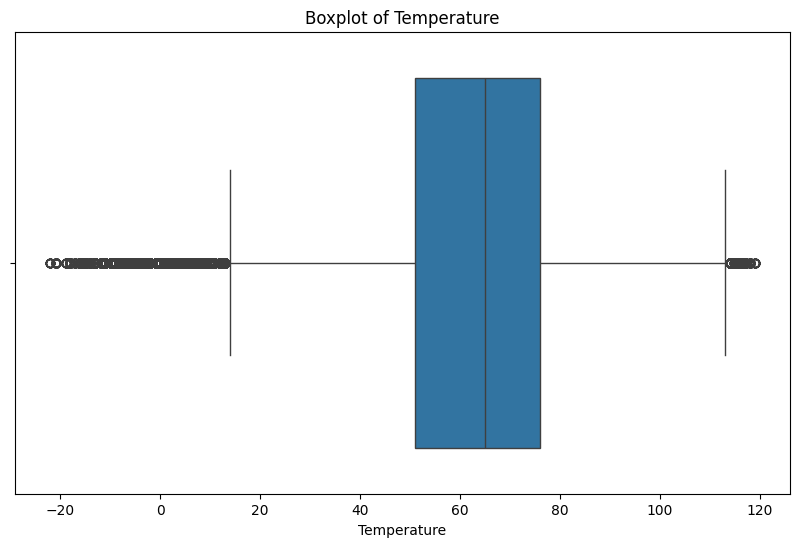

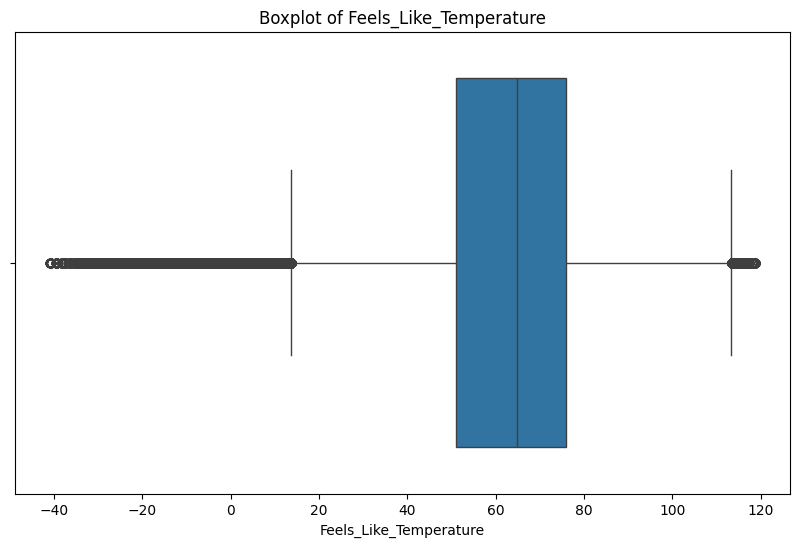

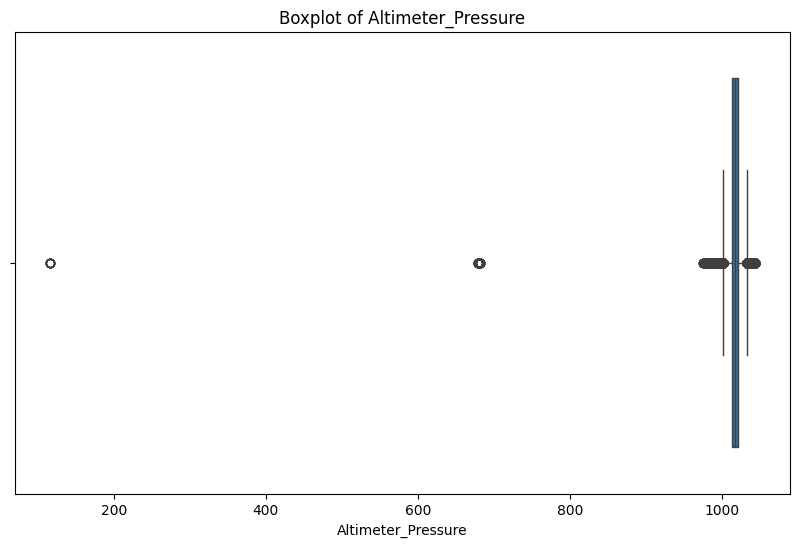

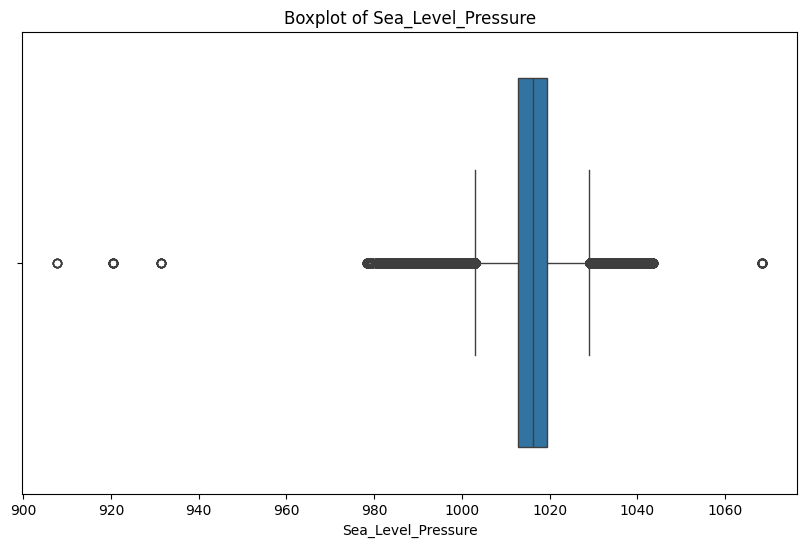

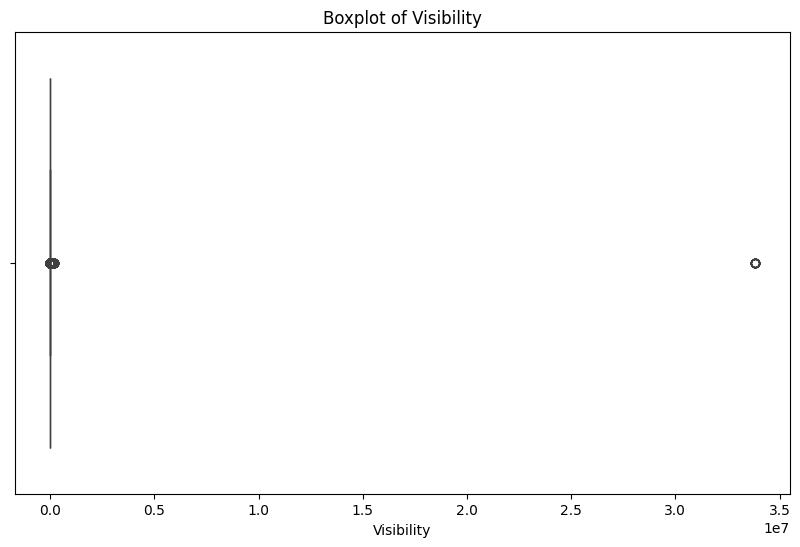

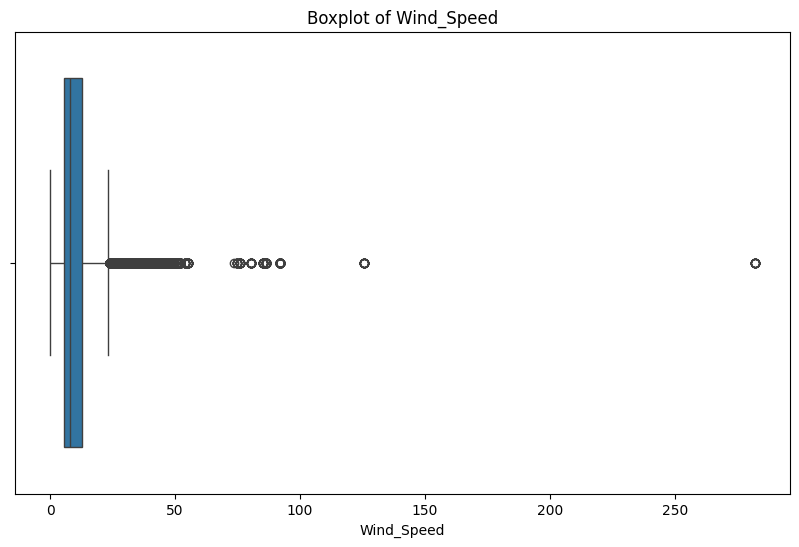

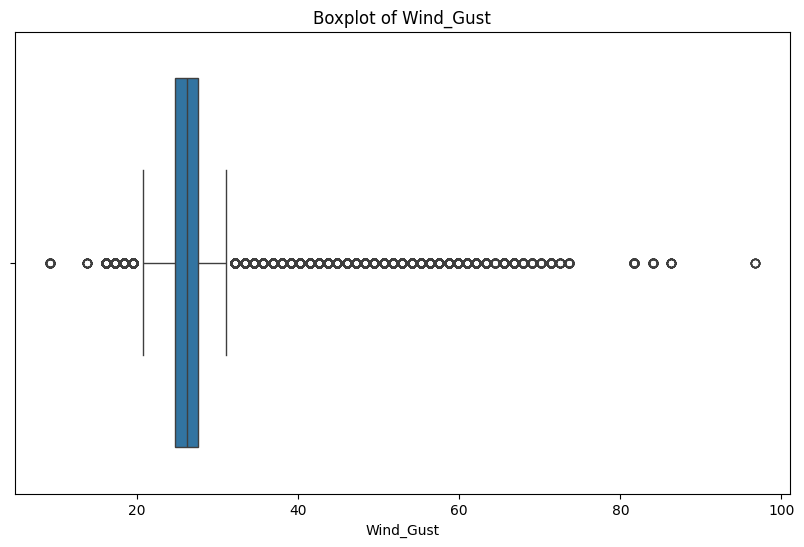

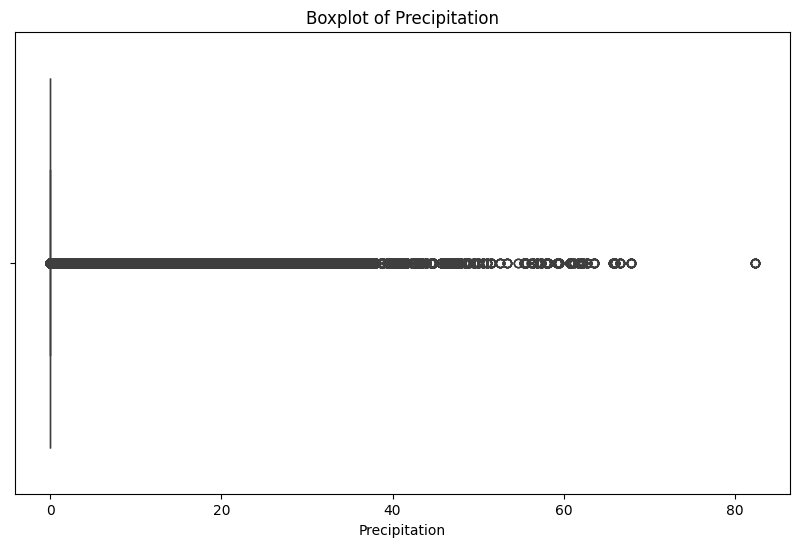

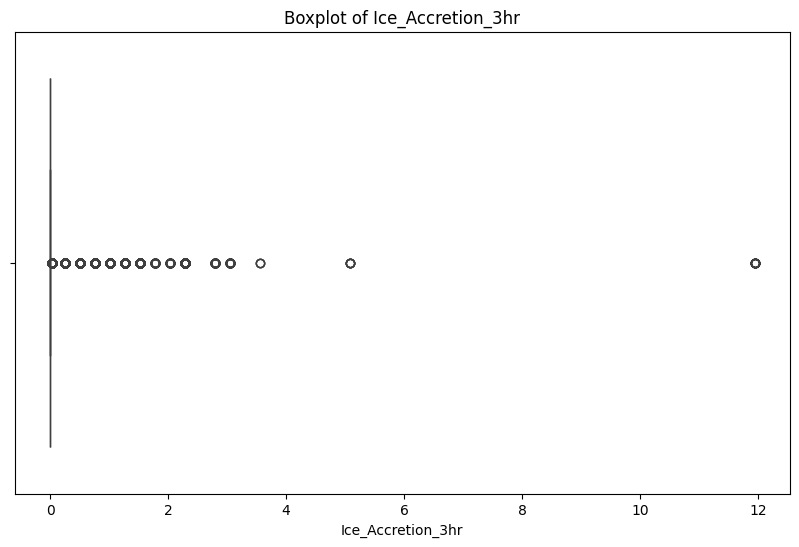

In [78]:
# Visualize outliers in specific columns
for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

### Manually Inspecting Extreme Outliers

In [79]:
# Define a function to identify and print extreme outliers for a given feature
def inspect_outliers(df, feature):
    # Calculate the Interquartile Range (IQR)
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier criteria: below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify extreme outliers
    extreme_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    # Print information about the outliers
    print(f"Feature: {feature}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Number of Extreme Outliers: {len(extreme_outliers)}")
    print(extreme_outliers[[feature]].head(20))  # Show top 20 outliers for inspection
    print("\n" + "-"*80 + "\n")

# List of features for which to inspect outliers
features_to_inspect = [
    'DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
    'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature', 'Altimeter_Pressure', 
    'Sea_Level_Pressure', 'Visibility', 'Wind_Speed', 'Wind_Gust', 
    'Precipitation', 'Ice_Accretion_3hr'
]

# Loop through each feature and inspect outliers
for feature in features_to_inspect:
    inspect_outliers(df, feature)

Feature: DepDelayMinutes
Lower Bound: -15.0
Upper Bound: 25.0
Number of Extreme Outliers: 2333489
     DepDelayMinutes
2               28.0
3               28.0
38              76.0
46              34.0
69              87.0
70              87.0
76              34.0
112            265.0
113            265.0
127             44.0
133            390.0
153             35.0
242             40.0
243             40.0
290             30.0
303             42.0
304             42.0
342             72.0
366             40.0
395            355.0

--------------------------------------------------------------------------------

Feature: CarrierDelay
Lower Bound: 0.0
Upper Bound: 0.0
Number of Extreme Outliers: 1925686
     CarrierDelay
2            28.0
3            28.0
38           59.0
46           31.0
54            9.0
112         265.0
113         265.0
127          37.0
133         390.0
153          35.0
177          14.0
181          20.0
236           2.0
242          23.0
243          23.

### Manually Treating Extreme Outliers

In [80]:
# Departure Delay Minutes
df['DepDelayMinutes'] = np.clip(df['DepDelayMinutes'], -15.0, 25.0)

In [81]:
# Carrier Delay
df['CarrierDelay'] = np.clip(df['CarrierDelay'], 0.0, 390.0)

In [82]:
#Weather Delay
df['WeatherDelay'] = np.clip(df['WeatherDelay'], 0.0, 140.0)

In [83]:
#NASDelay
df['NASDelay'] = np.clip(df['NASDelay'], 0.0, 247.0)

In [84]:
#Security Delay
df['SecurityDelay'] = np.clip(df['SecurityDelay'], 0.0, 146.0)

In [85]:
#LateAircraft Delay
df['LateAircraftDelay'] = np.clip(df['LateAircraftDelay'], 0.0, 111.0)

In [86]:
#Temperature
df['Temperature'] = np.clip(df['Temperature'], 13.5, 113.5)

In [87]:
#Feels_Like_Temperature
df['Feels_Like_Temperature'] = np.clip(df['Feels_Like_Temperature'], 13.75, 113.35)

In [88]:
#Altimeter Pressure
df['Altimeter_Pressure'] = np.clip(df['Altimeter_Pressure'], 1000.8449999999998, 1032.005)

In [89]:
#Sea_Level_Pressure
df['Sea_Level_Pressure'] = np.clip(df['Sea_Level_Pressure'], 1003.05, 1029.05)

In [90]:
#Visibility
df['Visibility'] = df['Visibility'].clip(lower=0, upper=16093.4)

In [91]:
#Wind Speed
df['Wind_Speed'] = np.clip(df['Wind_Speed'], 0.0, 23.025)

In [92]:
#Wind Gust
df['Wind_Gust'] = np.clip(df['Wind_Gust'], 20.42, 31.94)


In [93]:
#Precipitation
df['Precipitation'] = np.clip(df['Precipitation'], 0.0, 5.59)

In [94]:
#Ice Accretion
df['Ice_Accretion_3hr'] = np.clip(df['Ice_Accretion_3hr'], 0.0, 1.78)

Outliers found: 1954889


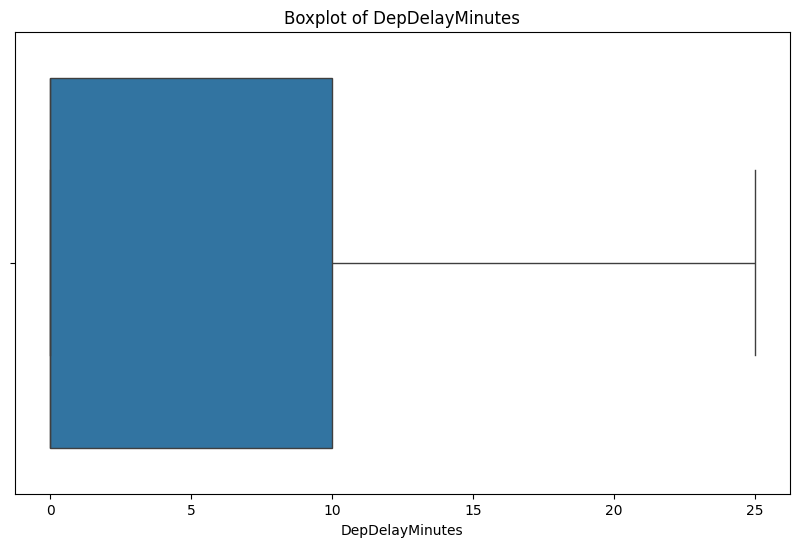

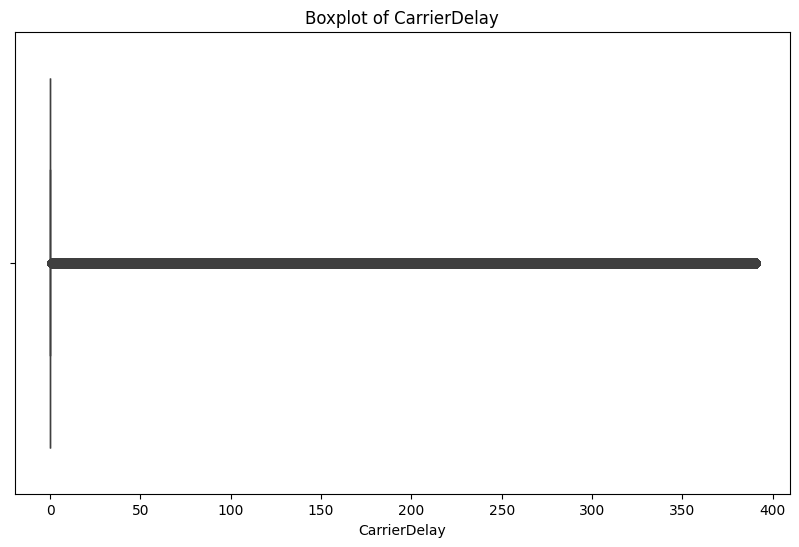

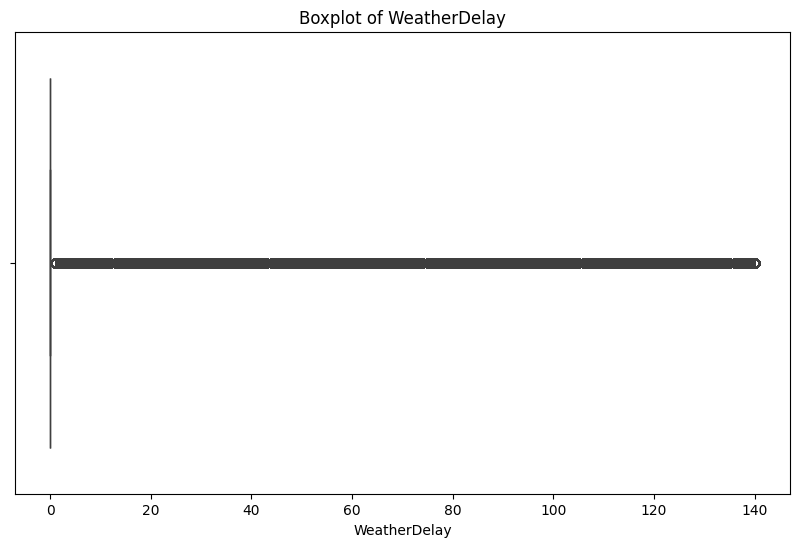

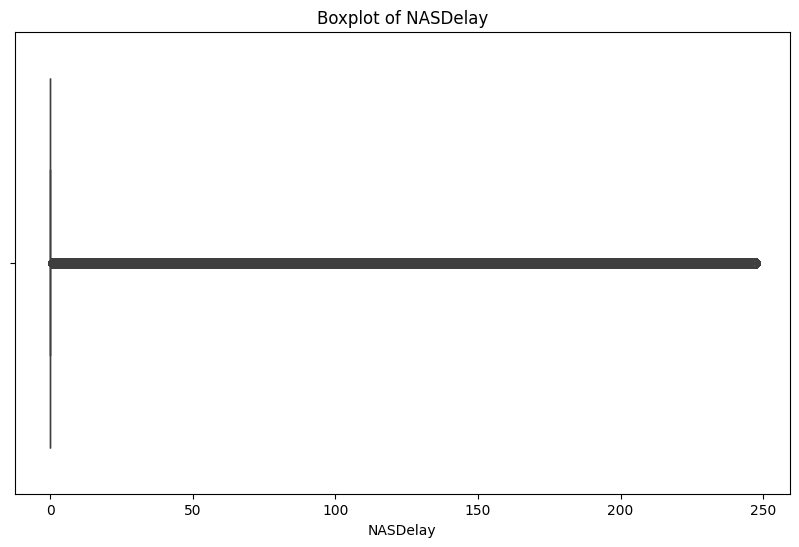

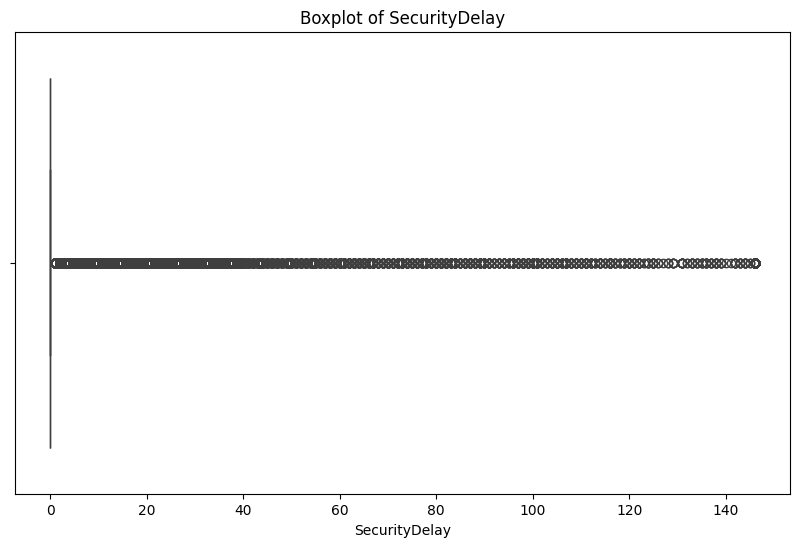

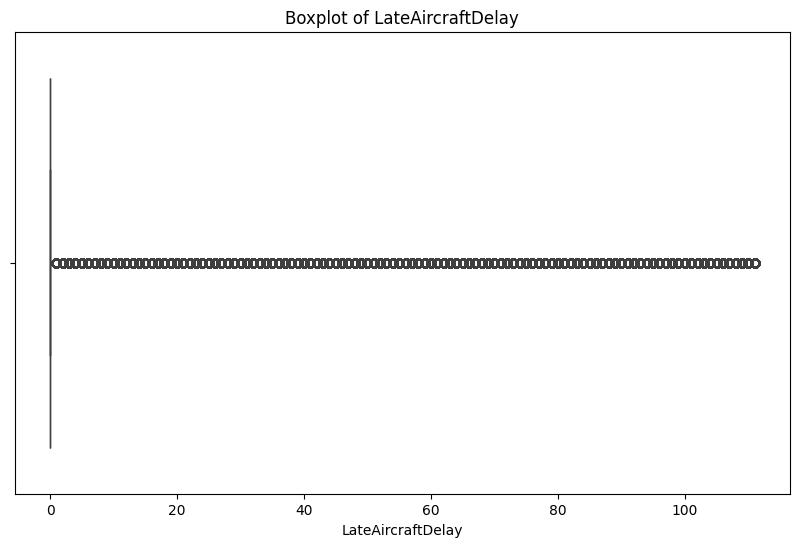

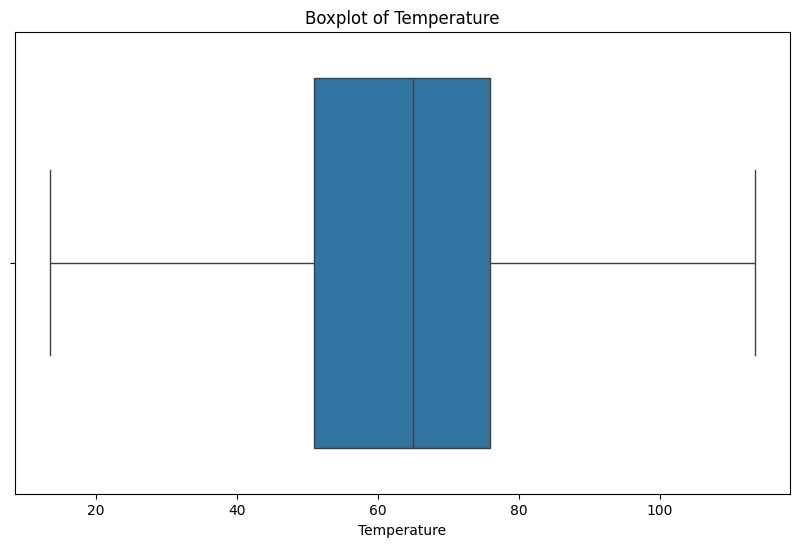

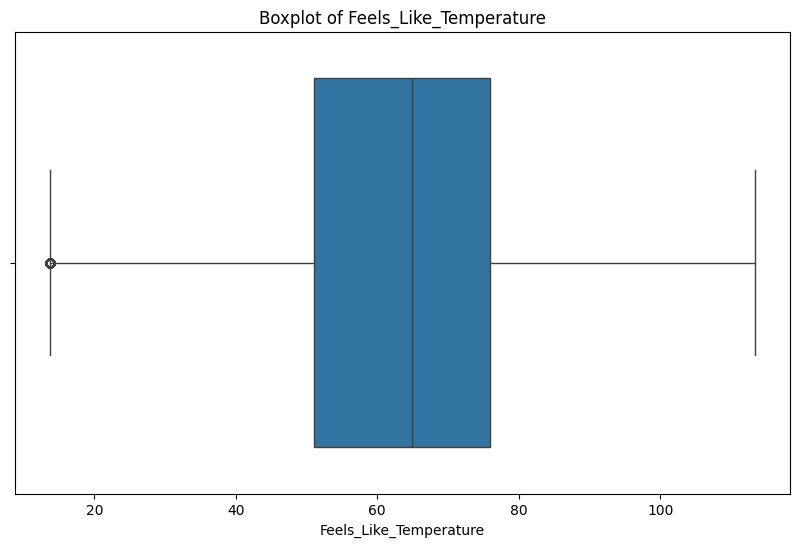

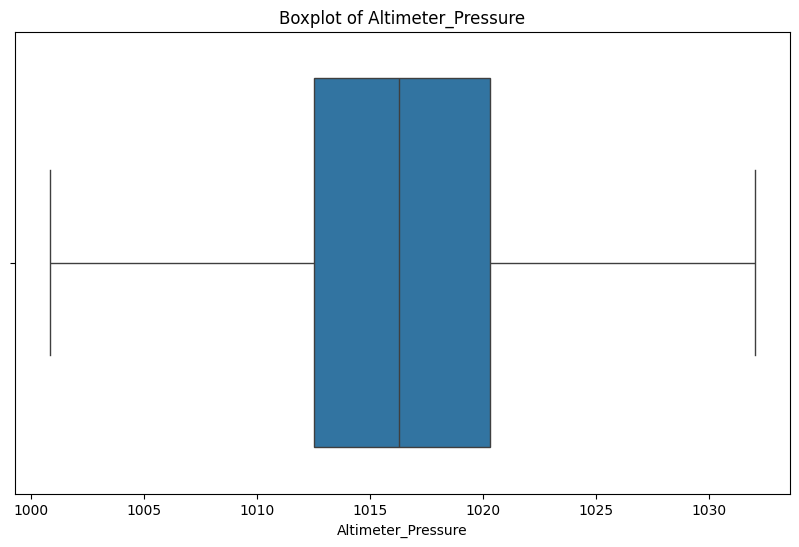

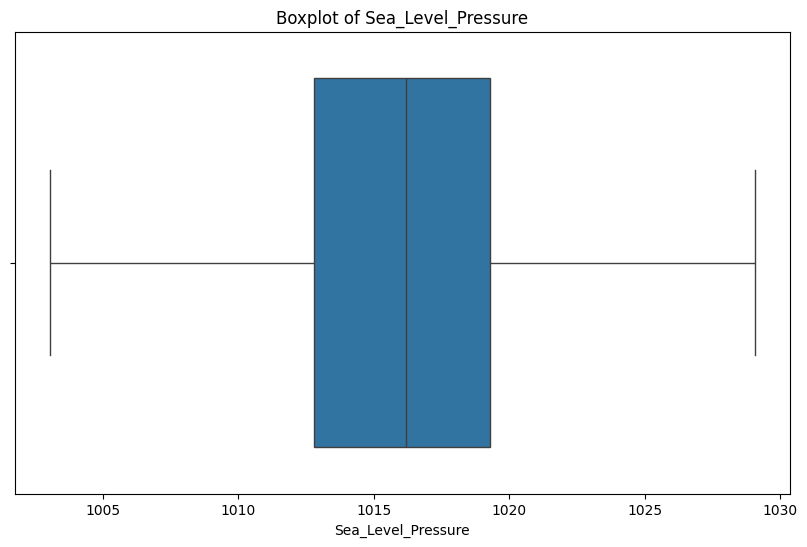

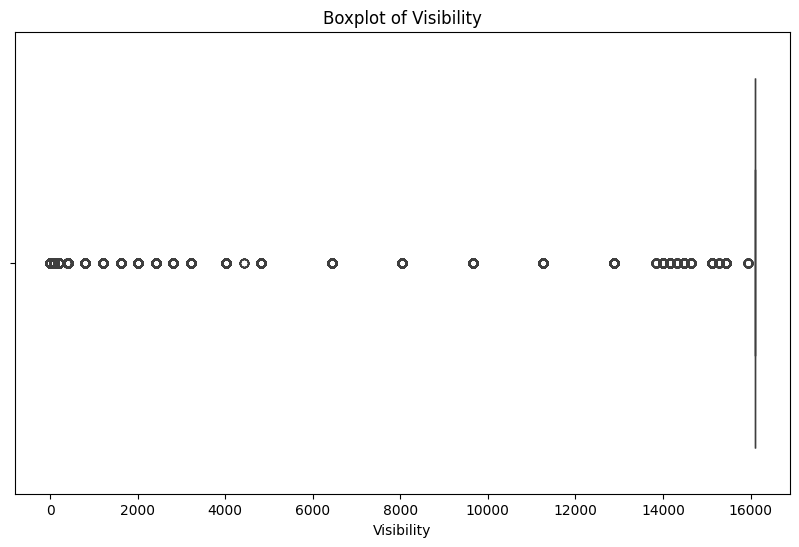

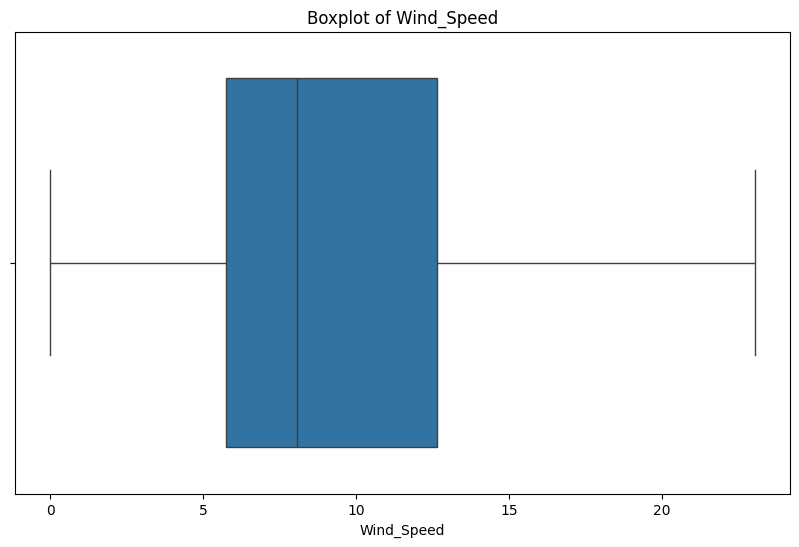

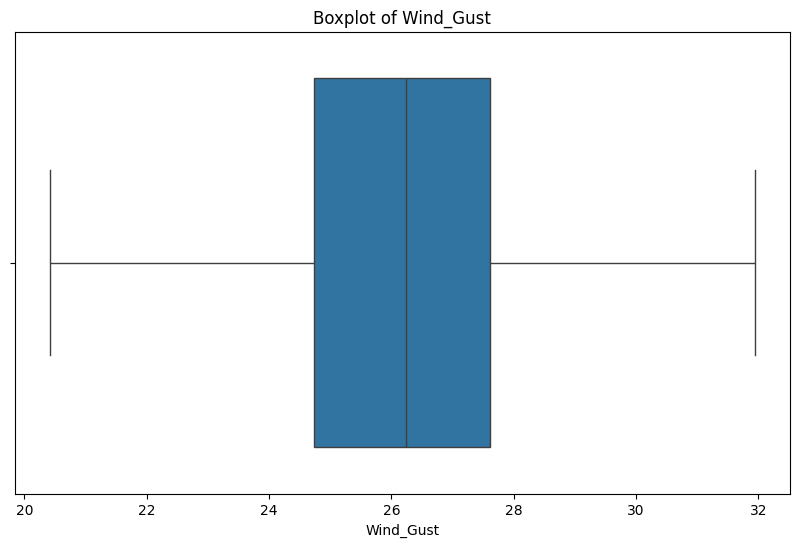

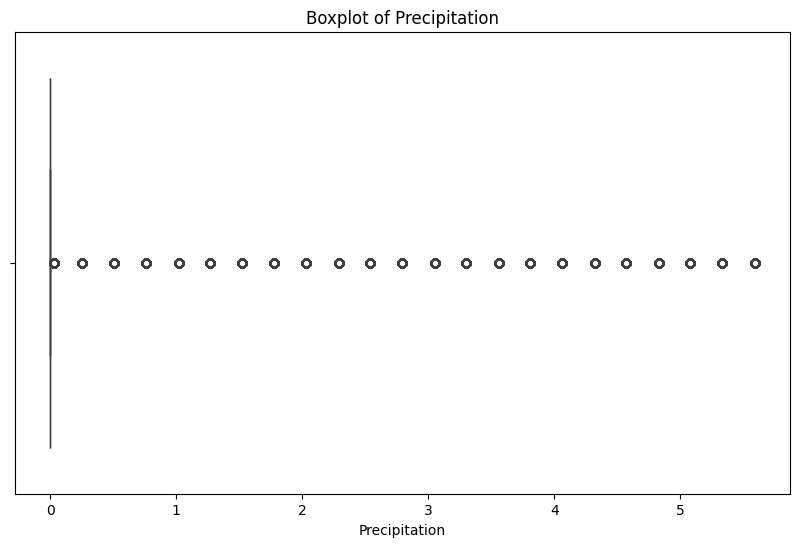

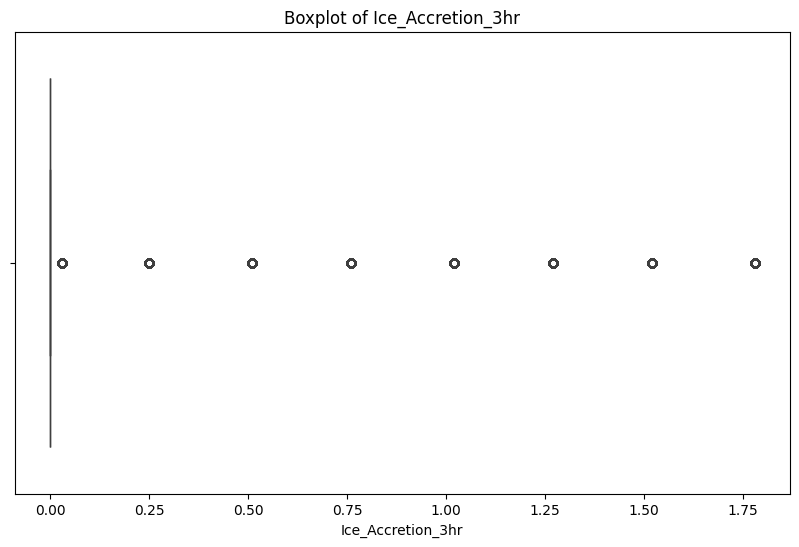

In [95]:
# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print(f"Outliers found: {len(outliers[0])}")

# Visualize outliers in specific columns
for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()